In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('class_parrafos.csv')
data = data[['nombre', 'industria', 'autor', 'y_pred']]
data.columns = ['nombre', 'industria', 'autor', 'isc']
print(data.shape)
data.head()

(765, 4)


,nombre,industria,autor,isc
0,AES Gener,Energía,Presidente,1
1,AES Gener,Energía,Presidente,1
2,AES Gener,Energía,Presidente,1
3,AES Gener,Energía,Presidente,0
4,AES Gener,Energía,Presidente,1


In [3]:
indices = data.groupby(['nombre', 'industria', 'autor']).mean()
indices = indices.reset_index()
indices.to_csv('01_indices.csv', index=False, encoding='utf-8-sig')
indices.head()

,nombre,industria,autor,isc
0,AES Gener,Energía,Presidente,0.666667
1,Aguas Andinas,Servicios Básicos,Gerente,0.500000
2,Aguas Andinas,Servicios Básicos,Presidente,0.461538
3,BCI,Financiera,Presidente,0.642857
4,Banco Santander,Financiera,Gerente,0.740741


In [4]:
presidentes = indices[indices['autor']=='Presidente']
presidentes = presidentes.drop('autor', axis=1)
presidentes = presidentes.sort_values(by='isc', ignore_index=True)
presidentes.to_csv('02_presidentes.csv', index=False, encoding='utf-8-sig')
presidentes.head()

,nombre,industria,isc
0,Grupo Security,Financiera,0.363636
1,Engie,Energía,0.363636
2,Banco Santander,Financiera,0.406250
3,Enel Chile,Servicios Básicos,0.448276
4,CSAV,Tecnología y Transporte,0.450000


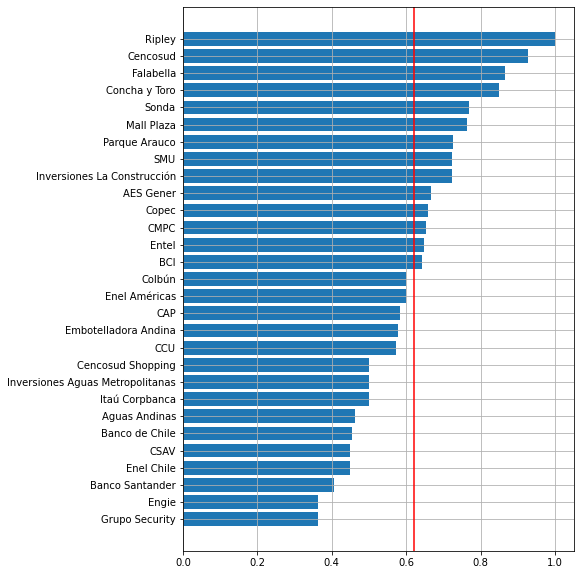

In [5]:
fig = plt.figure(figsize=(7,10))
plt.barh(presidentes.index, presidentes['isc'], tick_label=presidentes['nombre'])
plt.axvline(presidentes['isc'].mean(), color='red')
plt.grid()

In [6]:
gerentes = indices[indices['autor']=='Gerente']
gerentes = gerentes.drop('autor', axis=1)
gerentes = gerentes.sort_values(by='isc', ignore_index=True)
gerentes.to_csv('03_gerentes.csv', index=False, encoding='utf-8-sig')
gerentes.head()

,nombre,industria,isc
0,Aguas Andinas,Servicios Básicos,0.500000
1,Itaú Corpbanca,Financiera,0.578947
2,Parque Arauco,Comercio,0.600000
3,Inversiones La Construcción,Financiera,0.636364
4,Engie,Energía,0.666667


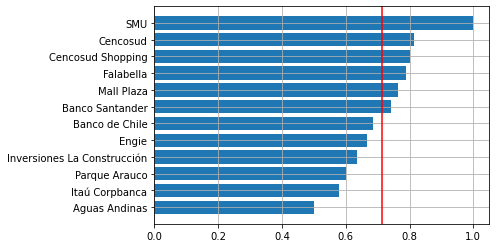

In [7]:
fig = plt.figure()
plt.barh(gerentes.index, gerentes['isc'], tick_label=gerentes['nombre'])
plt.axvline(gerentes['isc'].mean(), color='red')
plt.grid()

In [8]:
gp = gerentes.merge(presidentes, on='nombre', how='left')
gp = gp[['nombre', 'industria_x', 'isc_x', 'isc_y']]
gp.columns = ['nombre', 'industria', 'gerentes', 'presidentes']
gp

,nombre,industria,gerentes,presidentes
0,Aguas Andinas,Servicios Básicos,0.500000,0.461538
1,Itaú Corpbanca,Financiera,0.578947,0.500000
2,Parque Arauco,Comercio,0.600000,0.727273
3,Inversiones La Construcción,Financiera,0.636364,0.722222
4,Engie,Energía,0.666667,0.363636
5,Banco de Chile,Financiera,0.684211,0.454545
6,Banco Santander,Financiera,0.740741,0.406250
7,Mall Plaza,Comercio,0.764706,0.764706
8,Falabella,Comercio,0.789474,0.866667
9,Cencosud Shopping,Comercio,0.800000,0.500000


In [9]:
# Promedio de optimismo
gp.mean().round(2)

gerentes       0.71
presidentes    0.62
dtype: float64

In [10]:
gp['diferencia'] = gp['gerentes'] - gp['presidentes']
gp = gp.sort_values(by='diferencia', ignore_index=True)
gp.to_csv('04_gp.csv', index=False, encoding='utf-8-sig')

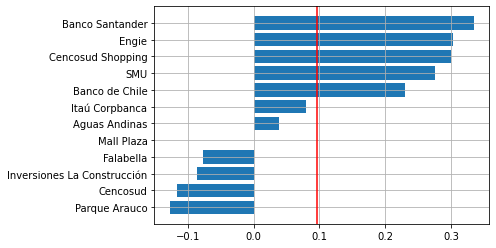

In [11]:
fig = plt.figure()
plt.barh(gp.index, gp['diferencia'], tick_label=gp['nombre'])
plt.axvline(gp['diferencia'].mean(), color='red')
plt.grid()

In [12]:
industrias = presidentes.groupby('industria').mean().reset_index().sort_values(by='isc', ignore_index=True)
industrias.to_csv('05_industrias.csv', index=False, encoding='utf-8-sig')
industrias

,industria,isc
0,Servicios Básicos,0.469938
1,Financiera,0.514919
2,Energía,0.557576
3,Manufactura,0.617754
4,Tecnología y Transporte,0.631743
5,Bebidas,0.666792
6,Comercio,0.787336


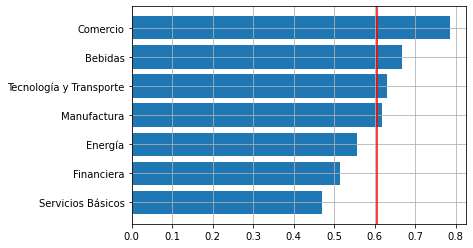

In [13]:
fig = plt.figure()
plt.barh(industrias.index, industrias['isc'], tick_label=industrias['industria'])
plt.axvline(industrias['isc'].mean(), color='red')
plt.grid()

In [14]:
ipsa = presidentes.mean().round(2)
print('Indice IPSA:', ipsa['isc'])

Indice IPSA: 0.62


# Resultados por industria

In [15]:
presidentes['industria'].value_counts()

Comercio                   7
Financiera                 6
Tecnología y Transporte    4
Energía                    4
Servicios Básicos          3
Bebidas                    3
Manufactura                2
Name: industria, dtype: int64

In [16]:
comercio = presidentes[presidentes['industria']=='Comercio'].sort_values(by='isc', ignore_index=True)
comercio = comercio.drop('industria', axis=1)
comercio = comercio.set_index('nombre')
comercio.to_csv('06_comercio.csv', encoding='utf-8-sig')

print('Más optimista:', comercio['isc'].idxmax())
print('Menos optimista:', comercio['isc'].idxmin())
comercio

Más optimista: Ripley
Menos optimista: Cencosud Shopping


,isc
nombre,
Cencosud Shopping,0.500000
SMU,0.724138
Parque Arauco,0.727273
Mall Plaza,0.764706
Falabella,0.866667
Cencosud,0.928571
Ripley,1.000000


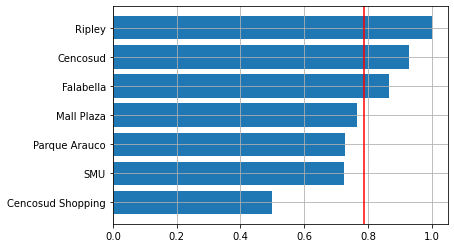

In [17]:
fig = plt.figure()
plt.barh(comercio.index, comercio['isc'])
plt.axvline(comercio['isc'].mean(), color='red')
plt.grid()

In [18]:
financiera = presidentes[presidentes['industria']=='Financiera'].sort_values(by='isc', ignore_index=True)
financiera = financiera.drop('industria', axis=1)
financiera = financiera.set_index('nombre')
financiera.to_csv('07_financiera.csv', encoding='utf-8-sig')

print('Más optimista:', financiera['isc'].idxmax())
print('Menos optimista:', financiera['isc'].idxmin())
financiera

Más optimista: Inversiones La Construcción
Menos optimista: Grupo Security


,isc
nombre,
Grupo Security,0.363636
Banco Santander,0.406250
Banco de Chile,0.454545
Itaú Corpbanca,0.500000
BCI,0.642857
Inversiones La Construcción,0.722222


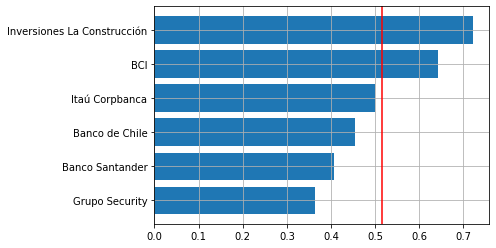

In [19]:
fig = plt.figure()
plt.barh(financiera.index, financiera['isc'])
plt.axvline(financiera['isc'].mean(), color='red')
plt.grid()

In [20]:
energia = presidentes[presidentes['industria']=='Energía'].sort_values(by='isc', ignore_index=True)
energia = energia.drop('industria', axis=1)
energia = energia.set_index('nombre')
energia.to_csv('08_energia.csv', encoding='utf-8-sig')

print('Más optimista:', energia['isc'].idxmax())
print('Menos optimista:', energia['isc'].idxmin())
energia

Más optimista: AES Gener
Menos optimista: Engie


,isc
nombre,
Engie,0.363636
Enel Américas,0.600000
Colbún,0.600000
AES Gener,0.666667


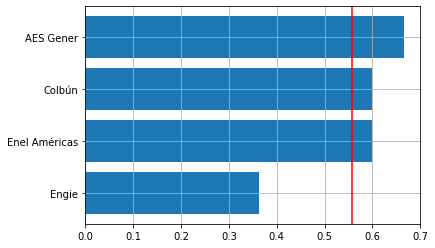

In [21]:
fig = plt.figure()
plt.barh(energia.index, energia['isc'])
plt.axvline(energia['isc'].mean(), color='red')
plt.grid()

In [22]:
tyt = presidentes[presidentes['industria']=='Tecnología y Transporte'].sort_values(by='isc', ignore_index=True)
tyt = tyt.drop('industria', axis=1)
tyt = tyt.set_index('nombre')
tyt.to_csv('09_tyt.csv', encoding='utf-8-sig')

print('Más optimista:', tyt['isc'].idxmax())
print('Menos optimista:', tyt['isc'].idxmin())
tyt

Más optimista: Sonda
Menos optimista: CSAV


,isc
nombre,
CSAV,0.450000
Entel,0.648649
Copec,0.659091
Sonda,0.769231


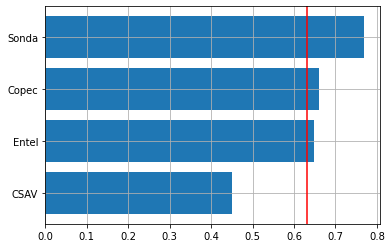

In [23]:
fig = plt.figure()
plt.barh(tyt.index, tyt['isc'])
plt.axvline(tyt['isc'].mean(), color='red')
plt.grid()

In [24]:
servicios = presidentes[presidentes['industria']=='Servicios Básicos'].sort_values(by='isc', ignore_index=True)
servicios = servicios.drop('industria', axis=1)
servicios = servicios.set_index('nombre')
servicios.to_csv('10_servicios.csv', encoding='utf-8-sig')

print('Más optimista:', servicios['isc'].idxmax())
print('Menos optimista:', servicios['isc'].idxmin())
servicios

Más optimista: Inversiones Aguas Metropolitanas
Menos optimista: Enel Chile


,isc
nombre,
Enel Chile,0.448276
Aguas Andinas,0.461538
Inversiones Aguas Metropolitanas,0.500000


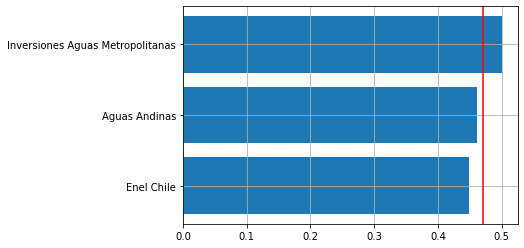

In [25]:

fig = plt.figure()
plt.barh(servicios.index, servicios['isc'])
plt.axvline(servicios['isc'].mean(), color='red')
plt.grid()


In [26]:
bebidas = presidentes[presidentes['industria']=='Bebidas'].sort_values(by='isc', ignore_index=True)
bebidas = bebidas.drop('industria', axis=1)
bebidas = bebidas.set_index('nombre')
bebidas.to_csv('11_bebidas.csv', encoding='utf-8-sig')

print('Más optimista:', bebidas['isc'].idxmax())
print('Menos optimista:', bebidas['isc'].idxmin())
bebidas

Más optimista: Concha y Toro
Menos optimista: CCU


,isc
nombre,
CCU,0.571429
Embotelladora Andina,0.578947
Concha y Toro,0.850000


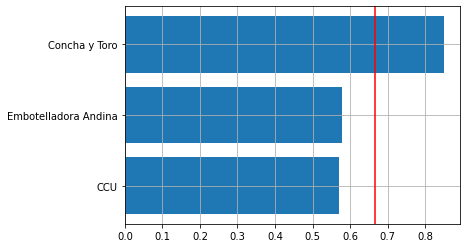

In [27]:
fig = plt.figure()
plt.barh(bebidas.index, bebidas['isc'])
plt.axvline(bebidas['isc'].mean(), color='red')
plt.grid()

In [28]:
manufactura = presidentes[presidentes['industria']=='Manufactura'].sort_values(by='isc', ignore_index=True)
manufactura = manufactura.drop('industria', axis=1)
manufactura = manufactura.set_index('nombre')
manufactura.to_csv('12_manufactura.csv', encoding='utf-8-sig')

print('Más optimista:', manufactura['isc'].idxmax())
print('Menos optimista:', manufactura['isc'].idxmin())
manufactura

Más optimista: CMPC
Menos optimista: CAP


,isc
nombre,
CAP,0.583333
CMPC,0.652174


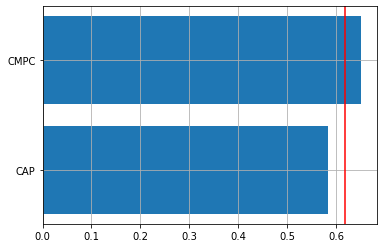

In [29]:
fig = plt.figure()
plt.barh(manufactura.index, manufactura['isc'])
plt.axvline(manufactura['isc'].mean(), color='red')
plt.grid()